# How to stream

!!! info "Prerequisites"

    This guide assumes familiarity with the following:
    
    - [Streaming](../../concepts/streaming/)
    - [Chat Models](https://python.langchain.com/docs/concepts/chat_models/)

Streaming is crucial for enhancing the responsiveness of applications built on LLMs. By displaying output progressively, even before a complete response is ready, streaming significantly improves user experience (UX), particularly when dealing with the latency of LLMs.

LangGraph is built with first class support for streaming. There are several different ways to stream back outputs from a graph run:

- `"values"`: Emit all values in the state after each step.
- `"updates"`: Emit only the node names and updates returned by the nodes after each step.
    If multiple updates are made in the same step (e.g. multiple nodes are run) then those updates are emitted separately.
- `"custom"`: Emit custom data from inside nodes using `StreamWriter`.
- [`"messages"`](../streaming-tokens): Emit LLM messages token-by-token together with metadata for any LLM invocations inside nodes.
- `"debug"`: Emit debug events with as much information as possible for each step.

You can stream outputs from the graph by using `graph.stream(..., stream_mode=<stream_mode>)` method, e.g.:

=== "Sync"

    ```python
    for chunk in graph.stream(inputs, stream_mode="updates"):
        print(chunk)
    ```

=== "Async"

    ```python
    async for chunk in graph.astream(inputs, stream_mode="updates"):
        print(chunk)
    ```

You can also combine multiple streaming mode by providing a list to `stream_mode` parameter:

=== "Sync"

    ```python
    for chunk in graph.stream(inputs, stream_mode=["updates", "custom"]):
        print(chunk)
    ```

=== "Async"

    ```python
    async for chunk in graph.astream(inputs, stream_mode=["updates", "custom"]):
        print(chunk)
    ```

## Setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

Let's define a simple graph with two nodes:

## Define graph

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START


class State(TypedDict):
    topic: str
    joke: str


def refine_topic(state: State):
    return {"topic": state["topic"] + " and cats"}


def generate_joke(state: State):
    return {"joke": f"This is a joke about {state['topic']}"}

def generate_joke2(state: State):
    return {"joke": f"2This is a joke about {state['topic']}"}



graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_node(generate_joke2)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .add_edge("generate_joke", "generate_joke2")
    .compile()
)

## Stream all values in the state (stream_mode="values") {#values}

Use this to stream **all values** in the state after each step.

In [7]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="values",
):
    print(chunk)

{'topic': 'ice cream'}
{'topic': 'ice cream and cats'}
{'topic': 'ice cream and cats', 'joke': 'This is a joke about ice cream and cats'}
{'topic': 'ice cream and cats', 'joke': '2This is a joke about ice cream and cats'}


## Stream state updates from the nodes (stream_mode="updates") {#updates}

Use this to stream only the **state updates** returned by the nodes after each step. The streamed outputs include the name of the node as well as the update.

In [5]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="updates",
):
    print(chunk)

{'refine_topic': {'topic': 'ice cream and cats'}}
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}
{'generate_joke2': {'joke': '2This is a joke about ice cream and cats'}}


## Stream debug events (stream_mode="debug") {#debug}

Use this to stream **debug events** with as much information as possible for each step. Includes information about tasks that were scheduled to be executed as well as the results of the task executions.

In [7]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="debug",
):
    print(chunk)
    print("\n---------")

{'type': 'task', 'timestamp': '2025-03-20T09:32:00.809182+00:00', 'step': 1, 'payload': {'id': 'b476d93a-ba66-65a6-4f58-dc4828ea639e', 'name': 'refine_topic', 'input': {'topic': 'ice cream'}, 'triggers': ('branch:to:refine_topic', 'start:refine_topic')}}

---------
{'type': 'task_result', 'timestamp': '2025-03-20T09:32:00.812258+00:00', 'step': 1, 'payload': {'id': 'b476d93a-ba66-65a6-4f58-dc4828ea639e', 'name': 'refine_topic', 'error': None, 'result': [('topic', 'ice cream and cats')], 'interrupts': []}}

---------
{'type': 'task', 'timestamp': '2025-03-20T09:32:00.812546+00:00', 'step': 2, 'payload': {'id': '8141714c-730d-1b47-0ba9-8ef19cba0f18', 'name': 'generate_joke', 'input': {'topic': 'ice cream and cats'}, 'triggers': ('branch:to:generate_joke', 'refine_topic')}}

---------
{'type': 'task_result', 'timestamp': '2025-03-20T09:32:00.814381+00:00', 'step': 2, 'payload': {'id': '8141714c-730d-1b47-0ba9-8ef19cba0f18', 'name': 'generate_joke', 'error': None, 'result': [('joke', 'This

## Stream LLM tokens ([stream_mode="messages"](../streaming-tokens)) {#messages}

Use this to stream **LLM messages token-by-token** together with metadata for any LLM invocations inside nodes or tasks. Let's modify the above example to include LLM calls:

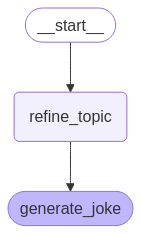

In [12]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

llm = ChatOpenAI(model="HuoShan/deepseek-v3",
                 temperature=0,
                 base_url="http://111.51.90.35:34521/sdk/v1/ai",
                 api_key="123")


def generate_joke(state: State):
    print(f"generate_joke: {state['topic']}")
    # highlight-next-line
    llm_response = llm.invoke(
        # highlight-next-line
        [
            # highlight-next-line
            {"role": "user", "content": f"Generate a joke about {state['topic']}"}
            # highlight-next-line
        ]
        # highlight-next-line
    )
    return {"joke": llm_response.content}


graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .compile()
)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
for message_chunk, metadata in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="messages",
):
    if message_chunk.content:
        print(message_chunk.content, end="|", flush=True)

generate_joke: ice cream and cats
Sure|!| Here|'s| a| pur|r|-f|ect|ly| sweet| joke| for| you|:

|Why| did| the| cat| start| an| ice| cream| truck|?|  
|Because| it| wanted| to| make| *|p|aw|-s|ome|*| flavors| like| *|me|ow|-ch|a|*| chip| and| *|pur|r|-s|icle|*| swirl|!| 🐾|🍦|result: Sure! Here's a purr-fectly sweet joke for you:

Why did the cat start an ice cream truck?  
Because it wanted to make *paw-some* flavors like *meow-cha* chip and *purr-sicle* swirl! 🐾🍦


In [9]:
metadata

{'langgraph_step': 2,
 'langgraph_node': 'generate_joke',
 'langgraph_triggers': ['refine_topic'],
 'langgraph_path': ('__pregel_pull', 'generate_joke'),
 'langgraph_checkpoint_ns': 'generate_joke:568879bc-8800-2b0d-a5b5-059526a4bebf',
 'checkpoint_ns': 'generate_joke:568879bc-8800-2b0d-a5b5-059526a4bebf',
 'ls_provider': 'openai',
 'ls_model_name': 'gpt-4o-mini',
 'ls_model_type': 'chat',
 'ls_temperature': 0.7}

## Stream custom data (stream_mode="custom") {#custom}

Use this to stream custom data from inside nodes using [`StreamWriter`][langgraph.types.StreamWriter].

In [18]:
from langgraph.types import StreamWriter


# highlight-next-line
def generate_joke(state: State, writer: StreamWriter):
    # highlight-next-line
    writer({"custom_key": "Writing custom data while generating a joke"})
    return {"joke": f"This is a joke about {state['topic']}"}


graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .compile()
)

In [19]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="custom",
):
    print(chunk)

{'custom_key': 'Writing custom data while generating a joke'}


## Configure multiple streaming modes {#multiple}

Use this to combine multiple streaming modes. The outputs are streamed as tuples `(stream_mode, streamed_output)`.

In [21]:
for stream_mode, chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode=["updates", "custom","values"],
):
    print(f"Stream mode: {stream_mode}")
    print(chunk)
    print("\n-----")

Stream mode: values
{'topic': 'ice cream'}

-----
Stream mode: updates
{'refine_topic': {'topic': 'ice cream and cats'}}

-----
Stream mode: values
{'topic': 'ice cream and cats'}

-----
Stream mode: custom
{'custom_key': 'Writing custom data while generating a joke'}

-----
Stream mode: updates
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}

-----
Stream mode: values
{'topic': 'ice cream and cats', 'joke': 'This is a joke about ice cream and cats'}

-----
